## Deploy Llava 1.6 with Mistral 7B Endpoint on SageMaker

In this notebook, we will deploy a Llava 1.6 endpoint with DJLServing container image.

This notebook has been tested within SageMaker Studio Notebook Instance with pytorch environment. 

### Setup

This notebook has been tested on Amazon SageMaker Notebook Instances with single GPU on ml.g5.2xlarge

In [29]:
!pip install huggingface_hub transformers==4.38.1 --upgrade --quiet

In [153]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

In [154]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [155]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "llava16-code"  # folder within bucket where code artifact will go
s3_model_prefix = "model-llava16"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-east-1-70768*******/model-llava16/


## Prepare inference script and container image

In [156]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.25.0"
)
inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.25.0-deepspeed0.11.0-cu118'

In this notebook, we will provide two ways to load the model when deploying to an endpoint.
- Directly load from Hugging Face 
- Store the model artifacts on S3 and load the model directly from S3

The [Large Model Inference (LMI)](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html) container uses [s5cmd](https://github.com/peak/s5cmd) to download data from S3 which significantly reduces the speed when loading model during deployment. Therefore, we recommend to load the model from S3 by following the below section to download the model from Hugging Face and upload the model on S3. 

If you choose to load the model directly from Hugging Face during model deployment, you can skip the below section and jump to the section to **prepare the model tarbal file and upload to S3**.

### [OPTIONAL] Download the model from Hugging Face and upload the model artifacts on Amazon S3
If you intend to download your copy of the model and upload it to a s3 location in your AWS account, please follow the below steps, else you can skip to the next step.

In [8]:
from huggingface_hub import snapshot_download
from pathlib import Path

model_name = "llava-hf/llava-v1.6-mistral-7b-hf"

# - This will download the model into the current directory where ever the jupyter notebook is running
local_model_path = Path("./llava-model")
local_model_path.mkdir(exist_ok=True)
# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model", "*.safetensors"]

# - Leverage the snapshot library to donload the model since the model is stored in repository using LFS
model_download_path = snapshot_download(
    repo_id=model_name,
    cache_dir=local_model_path,
    allow_patterns=allow_patterns,
)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

In [157]:
model_download_path

'llava-model/models--llava-hf--llava-v1.6-mistral-7b-hf/snapshots/4dbf61a5df5b38ec222b3acb12a947b5cef29312'

Please make sure the file is downloaded correctly by checking the files exist in the newly created folder `blip2-model/models--Salesforce--<model-name>/snapshots/...` before running the below cell.

In [158]:
# upload the model artifacts to s3
model_artifact = sess.upload_data(path=model_download_path, key_prefix=s3_model_prefix)
print(f"Model uploaded to --- > {model_artifact}")
print(f"We will set option.s3url={model_artifact}")

Model uploaded to --- > s3://sagemaker-us-east-1-70768*******/model-llava16
We will set option.s3url=s3://sagemaker-us-east-1-70768*******/model-llava16


In [161]:
#!rm -rf {local_model_path}

SageMaker Large Model Inference containers can be used to host models without providing your own inference code. This is extremely useful when there is no custom pre-processing of the input data or post-processing of the model's predictions.

However, in this notebook, we demonstrate how to deploy a model with custom inference code.

SageMaker needs the model artifacts to be in a Tarball format. In this example, we provide the following files - `serving.properties`, `model.py`, and `requirements.txt`.
- `serving.properties` is the configuration file that can be used to indicate to DJL Serving which model parallelization and inference optimization libraries you would like to use. Depending on your need, you can set the appropriate configuration. For more details on the configuration options and an exhaustive list, you can refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html).
- `model.py` is the script handles any requests for serving.
- `requirements.txt` is the text file containing any additional pip wheel need to install. 

If you want to download the model from huggingface.co, you can set option.model_id. The model id of a pretrained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co. If you set the model_id to a s3 url, the DJL will download the model artifacts from s3 and swap the model_id to the actual location of the model artifacts. In your script, you can point to this value to load the pre-trained model.
- `option.tensor_parallel_degree`: Set to the number of GPU devices over which the model needs to be partitioned. This parameter also controls the number of workers per model which will be started up when DJL serving runs. As an example if we have a 8 GPU machine, and we are creating 8 partitions then we will have 1 worker per model to serve the requests.


In [167]:
%%writefile llava-djl-config/serving.properties
engine = Python
option.tensor_parallel_degree = 1
option.model_loading_timeout = 600
option.model_id = {{s3url}}

Overwriting llava-djl-config/serving.properties


In [168]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("llava-djl-config/serving.properties").open().read())
Path("llava-djl-config/serving.properties").open("w").write(
    template.render(s3url=pretrained_model_location)
)
!pygmentize llava-djl-config/serving.properties | cat -n

     1	engine = Python
     2	option.tensor_parallel_degree = 1
     3	option.model_loading_timeout = 600
     4	option.model_id = s3://sagemaker-us-east-1-70768*******/model-llava16/


## Prepare the model tarball file and upload to S3

In [171]:
%%sh
tar czvf model.tar.gz llava-djl-config/

llava-djl-config/
llava-djl-config/model.py
llava-djl-config/requirements.txt
llava-djl-config/serving.properties


In [172]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-70768*******/llava16-code/model.tar.gz


## Deploy model

In [139]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

deploy_model_name = "llava-v16-mistral-7b-hf"
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=deploy_model_name,
)

In [140]:
%%time
endpoint_name = "endpoint-" + deploy_model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    endpoint_name=endpoint_name
)

Using already existing model: llava-v16-mistral-7b-hf


-----------!CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 6min 2s


In [152]:
endpoint_name 

'endpoint-llava-v16-mistral-7b-hf'

## Test Inference Endpoint

In [173]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name

In [174]:
def encode_image(img_file):
    with open(img_file, "rb") as image_file:
        img_str = base64.b64encode(image_file.read())
        base64_string = img_str.decode("latin1")
    return base64_string

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

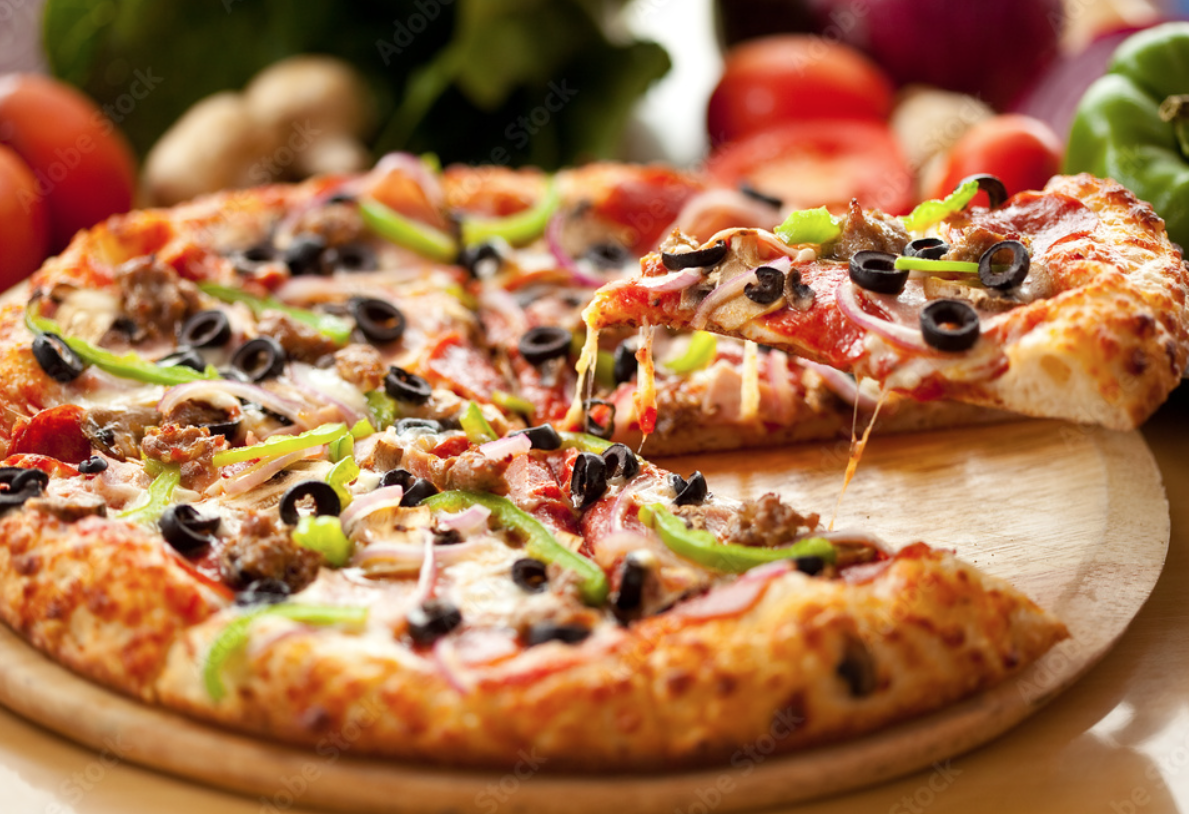

In [189]:
test_image = "food.png"
raw_image = Image.open(test_image).convert('RGB')
display(raw_image)

### Instructed zero-shot vision-to-language detailed caption generation

In [190]:
base64_string = encode_image(test_image)

prompt = "<image>\nUSER: What's the content of the image in details?\nASSISTANT:"

param = {
    "max_new_tokens": 500,
}


inputs = {"prompt": prompt, "image": base64_string, "parameters": param}
run_inference(endpoint_name, inputs)

"USER: What's the content of the image in details?\nASSISTANT: The image shows a close-up view of a pizza with various toppings. The pizza has a golden-brown crust and is generously covered with melted cheese. The toppings include black olives, green peppers, and what appears to be sausage. The pizza is sliced and ready to be served. In the background, there are other food items, including a tomato and some garlic bread, suggesting that this might be a meal from a restaurant or a pizzeria. The image is a high-resolution photograph with a focus on the pizza, making the details of the toppings and the texture of the crust quite clear."

### Instructed Visual Question Answering (VQA)

In [191]:
base64_string = encode_image(test_image)

prompt = "<image>\nUSER: Is it recommended for eating before sport? \nASSISTANT:"

param = {
    "max_new_tokens": 500,
}


inputs = {"prompt": prompt, "image": base64_string, "parameters": param}
run_inference(endpoint_name, inputs)

"USER: Is it recommended for eating before sport? \nASSISTANT: The image shows a pizza with various toppings, including olives, onions, and peppers. While pizza can be a convenient and tasty meal, it's not typically recommended as a pre-sport meal due to its high calorie and fat content. Consuming a meal high in fat and calories before physical activity can lead to discomfort and sluggishness during exercise. Instead, it's generally advised to eat a light, easily digestible meal or snack before sport, such as a banana, a granola bar, or a small serving of pasta."

In [196]:
base64_string = encode_image(test_image)

prompt = "<image>\nUSER: Can you list several descriptions for product marketing? \nASSISTANT:"

param = {
    "max_new_tokens": 500,
}


inputs = {"prompt": prompt, "image": base64_string, "parameters": param}
print(run_inference(endpoint_name, inputs))

USER: Can you list several descriptions for product marketing? 
ASSISTANT: Certainly! Here are several descriptions that could be used for marketing a pizza:

1. "Indulge in a mouthwatering feast with our gourmet pizza, topped with fresh vegetables, succulent meats, and a generous layer of melted cheese. Perfect for sharing with friends or enjoying a delicious meal on your own."

2. "Savor the flavors of Italy with our authentic pizza, made with the finest ingredients and baked to perfection. Whether you prefer a classic Margherita or something more adventurous, we have a pizza to suit every taste."

3. "Enjoy a slice of heaven with our artisan pizza, handcrafted with care and served hot and fresh. With a variety of toppings to choose from, there's a pizza for everyone at our restaurant."

4. "Treat yourself to a culinary delight with our specialty pizza, featuring unique and flavorful combinations of toppings. From BBQ chicken to veggie-loaded, we're sure to have a pizza that will sat

## Clean up
Uncomment the below cell to delete the endpoint and model when you finish the experiment

In [146]:
#sm_client.delete_model(ModelName=deploy_model_name)
#sm_client.delete_endpoint(EndpointName=endpoint_name)